In [92]:
# imports
import pandas as pd
import datetime as dt
import sklearn
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
warnings.filterwarnings('ignore')

In [93]:
df = pd.read_csv('sales_data_sample.csv', encoding='latin1')

After analyze of the dataset, for the k-means and hierarchical clustering, the outliers will be removed not to distort the algorithm; nevertheless, in DBSCAN they will not be removed and investigation of super customers (spending the most etc. as an outlier) will be visible in DBSCAN.

# Preprocessing and Transforming Dataset with RFM Analysis

In [94]:
# check if there are null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


No null values is present in the dataset.

In [95]:
# changing order date to datetime object
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [96]:
# only complete orders will be considered which are in the status of shipped and resolved
df['STATUS'].unique()

array(['Shipped', 'Disputed', 'In Process', 'Cancelled', 'On Hold',
       'Resolved'], dtype=object)

In [97]:
valid_statuses = ['Shipped', 'Resolved']
df = df[df['STATUS'].isin(valid_statuses)].copy()

In [98]:
snapshot_date = df['ORDERDATE'].max()

rfm_df = df.groupby('CUSTOMERNAME').agg(
    Recency=('ORDERDATE', lambda x: (snapshot_date - x.max()).days),
    Frequency=('ORDERNUMBER', 'nunique'),
    MonetaryValue=('SALES', 'sum')
).reset_index()

rfm_df

,CUSTOMERNAME,Recency,Frequency,MonetaryValue
0,"AV Stores, Co.",181,3,157807.81
1,Alpha Cognac,50,3,70488.44
2,Amica Models & Co.,250,2,94117.26
3,"Anna's Decorations, Ltd",69,4,153996.13
4,Atelier graphique,173,3,24179.96
...,...,...,...,...
87,"Vida Sport, Ltd",260,2,117713.56
88,Vitachrome Inc.,193,3,88041.26
89,"Volvo Model Replicas, Co",189,3,49494.67
90,West Coast Collectables Co.,474,2,46084.64


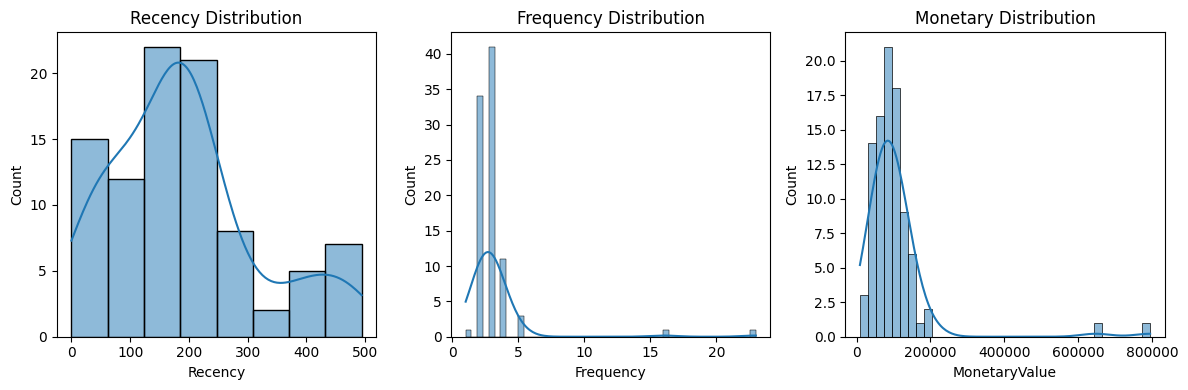

In [99]:
plt.figure(figsize=(12, 4))

# Plot Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Recency Distribution')

# Plot Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Frequency Distribution')

# Plot MonetaryValue
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['MonetaryValue'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [100]:
rfm_df[['Recency', 'Frequency', 'MonetaryValue']].skew()

,0
Recency,0.769220
Frequency,6.138049
MonetaryValue,5.392616


Since skewed data may disturb the algorithms and in our dataset most of the features are right skewed, log transformation will be applied.

In [101]:
# apply log transformation to highly skewed features
rfm_df['Frequency'] = np.log1p(rfm_df['Frequency'])
rfm_df['MonetaryValue'] = np.log1p(rfm_df['MonetaryValue'])

rfm_df[['Recency', 'Frequency', 'MonetaryValue']].skew()

,0
Recency,0.769220
Frequency,3.020343
MonetaryValue,0.186050


In [102]:
rfm_df['Frequency'] = np.log1p(rfm_df['Frequency'])
rfm_df[['Recency', 'Frequency', 'MonetaryValue']].skew()

,0
Recency,0.76922
Frequency,1.83115
MonetaryValue,0.18605


For frequency, log transformation is applied twice to reduce the skewness.

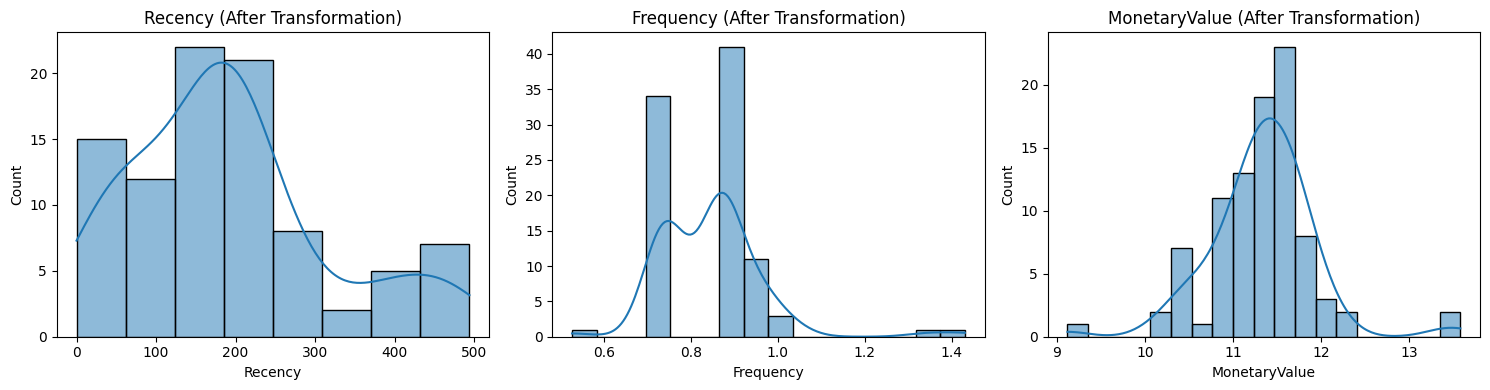

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['Recency', 'Frequency', 'MonetaryValue']):
    sns.histplot(rfm_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col} (After Transformation)')
plt.tight_layout()
plt.show()

In [104]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'MonetaryValue'])

rfm_scaled_df.head()

,Recency,Frequency,MonetaryValue
0,-0.065946,0.201302,1.070433
1,-1.138529,0.201302,-0.289512
2,0.499002,-0.869040,0.198309
3,-0.982963,0.946103,1.029175
4,-0.131447,0.201302,-2.094900


Now, outliers will be removed in a copy of our dataset to check clustering algorithm results.

In [105]:
# Create a copy for outlier removal
rfm_no_outliers = rfm_df.copy()

# Define the columns to check
cols = ['Recency', 'Frequency', 'MonetaryValue']

# Apply IQR filtering
for col in cols:
    Q1 = rfm_no_outliers[col].quantile(0.25)
    Q3 = rfm_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rfm_no_outliers = rfm_no_outliers[
        (rfm_no_outliers[col] >= lower_bound) & (rfm_no_outliers[col] <= upper_bound)
    ]

In [106]:
print(f"Original shape: {rfm_df.shape}")
print(f"After outlier removal: {rfm_no_outliers.shape}")
print(f"Total removed: {rfm_df.shape[0] - rfm_no_outliers.shape[0]}")

Original shape: (92, 4)
After outlier removal: (82, 4)
Total removed: 10


In [107]:
scaler = StandardScaler()
rfm_scaled_no_outliers = scaler.fit_transform(rfm_no_outliers[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled_no_outliers_df = pd.DataFrame(rfm_scaled_no_outliers, columns=['Recency', 'Frequency', 'MonetaryValue'])

rfm_scaled_no_outliers_df.head()

,Recency,Frequency,MonetaryValue
0,0.012219,0.330081,1.496596
1,-1.191953,0.330081,-0.549795
2,0.646477,-1.200761,0.184259
3,-1.017302,1.395323,1.434512
4,1.280736,-1.200761,-1.410992


# K-means clustering

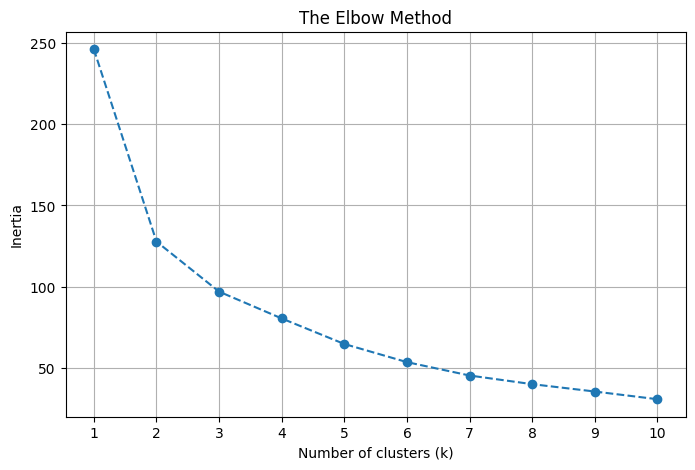

In [164]:
# Elbow method to find the best number of clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=100,
        max_iter=2000,
        random_state=42
    )
    kmeans.fit(rfm_scaled_no_outliers_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [173]:
kmeans = KMeans(
    n_clusters=2,
    init='k-means++',
    n_init=100,
    max_iter=2000,
    random_state=42
)
kmeans.fit(rfm_scaled_no_outliers_df)

cluster_labels = kmeans.labels_
rfm_with_clusters_df = rfm_no_outliers.copy()
rfm_with_clusters_df['Cluster'] = cluster_labels
rfm_with_clusters_df.head()

,CUSTOMERNAME,Recency,Frequency,MonetaryValue,Cluster
0,"AV Stores, Co.",181,0.869742,11.969140,0
1,Alpha Cognac,50,0.869742,11.163218,0
2,Amica Models & Co.,250,0.741276,11.452307,1
3,"Anna's Decorations, Ltd",69,0.959135,11.944689,0
5,"Australian Collectables, Ltd",319,0.741276,10.824057,1


In [193]:
print("\n--- Average RFM Values per Cluster ---")
cluster_analysis = rfm_with_clusters_df.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_MonetaryValue=('MonetaryValue', 'mean'),
    Count=('CUSTOMERNAME', 'count')
).sort_values(by='Avg_MonetaryValue', ascending=False)

cluster_analysis['Avg_Recency'] = cluster_analysis['Avg_Recency'].round(1)
cluster_analysis['Avg_Frequency'] = cluster_analysis['Avg_Frequency'].round(1)
cluster_analysis['Avg_MonetaryValue'] = cluster_analysis['Avg_MonetaryValue'].round(2)

print(cluster_analysis)


--- Average RFM Values per Cluster ---
         Avg_Recency  Avg_Frequency  Avg_MonetaryValue  Count
Cluster                                                      
0              120.1            0.9              11.52     53
1              288.5            0.8              11.12     29


In [195]:
fig = px.scatter_3d(rfm_with_clusters_df,
                    x='Recency',
                    y='Frequency',
                    z='MonetaryValue',
                    color='Cluster',
                    hover_name='CUSTOMERNAME',
                    title='3D View of Customer Segments')
fig.show()

In [196]:
features = ['Recency', 'Frequency', 'MonetaryValue']
silhouette = silhouette_score(rfm_with_clusters_df[features], cluster_labels)
dbi = davies_bouldin_score(rfm_with_clusters_df[features], cluster_labels)
ch = calinski_harabasz_score(rfm_with_clusters_df[features], cluster_labels)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")
print(f"Calinski-Harabasz Index: {ch:.2f}")

Silhouette Score: 0.439
Davies-Bouldin Index: 0.792
Calinski-Harabasz Index: 96.76


When metrics for cluster is analyzed, the best one is when clusters are 2. Therefore, the customers are divided based on their recency value (loyal and unloyal customers).

# Hierarchical Clustering

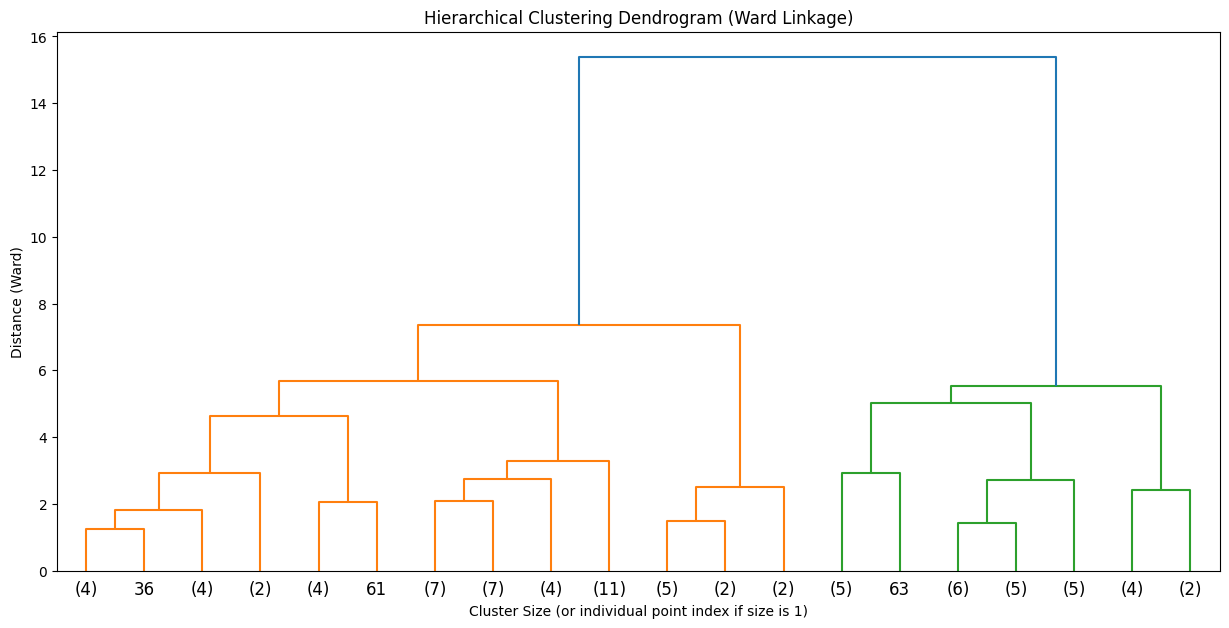

In [197]:
# dendrogram to choose the best number of clusters
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
linked = linkage(rfm_scaled_no_outliers_df, method='ward')

dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp',
           p=20
          )
plt.xlabel("Cluster Size (or individual point index if size is 1)")
plt.ylabel("Distance (Ward)")
plt.show()

In [198]:
agg_cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_labels = agg_cluster.fit_predict(rfm_scaled_no_outliers_df)
rfm_with_agg_clusters_df = rfm_no_outliers.copy()
rfm_with_agg_clusters_df['Cluster'] = agg_labels

print("\n--- Average RFM Values per Agglomerative Cluster ---")
agg_cluster_analysis = rfm_with_agg_clusters_df.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_MonetaryValue=('MonetaryValue', 'mean'),
    Count=('CUSTOMERNAME', 'count')
).sort_values(by='Avg_MonetaryValue', ascending=False)

agg_cluster_analysis['Avg_Recency'] = agg_cluster_analysis['Avg_Recency'].round(1)
agg_cluster_analysis['Avg_Frequency'] = agg_cluster_analysis['Avg_Frequency'].round(1)
agg_cluster_analysis['Avg_MonetaryValue'] = agg_cluster_analysis['Avg_MonetaryValue'].round(2)

print(agg_cluster_analysis)


--- Average RFM Values per Agglomerative Cluster ---
         Avg_Recency  Avg_Frequency  Avg_MonetaryValue  Count
Cluster                                                      
0              121.4            0.9              11.51     54
1              292.0            0.7              11.13     28


In [199]:
fig = px.scatter_3d(rfm_with_agg_clusters_df,
                    x='Recency',
                    y='Frequency',
                    z='MonetaryValue',
                    color='Cluster',
                    hover_name='CUSTOMERNAME',
                    title='3D View of Customer Segments')
fig.show()

In [200]:
silhouette = silhouette_score(rfm_with_agg_clusters_df[features], cluster_labels)
dbi = davies_bouldin_score(rfm_with_agg_clusters_df[features], cluster_labels)
ch = calinski_harabasz_score(rfm_with_agg_clusters_df[features], cluster_labels)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")
print(f"Calinski-Harabasz Index: {ch:.2f}")

Silhouette Score: 0.439
Davies-Bouldin Index: 0.792
Calinski-Harabasz Index: 96.76


Dendrogram also proves that longest vertical line appears when number of clusters are 2.

# DBSCAN Algorithm

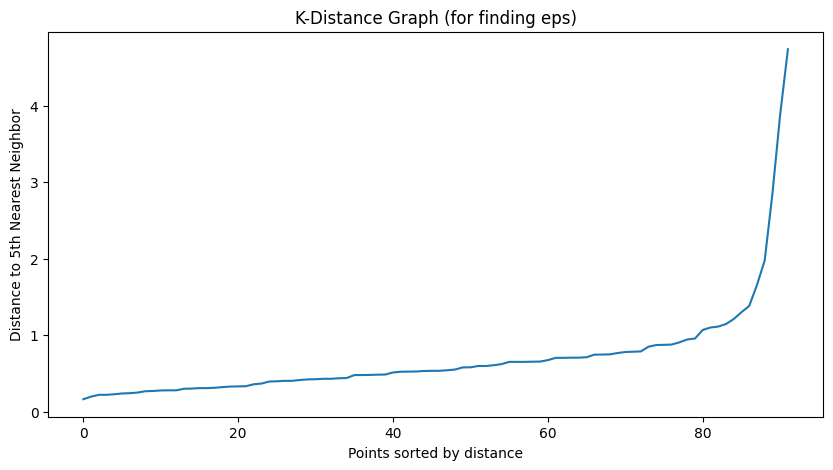

In [201]:
# We'll set min_samples = 6 (a good rule of thumb is 2 * num_dimensions, 2*3=6)
min_samples = 6
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(rfm_scaled_df)
distances, indices = neighbors_fit.kneighbors(rfm_scaled_df)

distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph (for finding eps)')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples-1}th Nearest Neighbor')
plt.savefig('dbscan_eps_plot.png')
plt.show()

In [202]:
dbscan = DBSCAN(eps=0.9, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(rfm_scaled_df)

rfm_with_dbscan_clusters_df = rfm_df.copy()
rfm_with_dbscan_clusters_df['Cluster'] = dbscan_labels

print("\n--- Average RFM Values per DBSCAN Cluster ---")
dbscan_cluster_analysis = rfm_with_dbscan_clusters_df.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_MonetaryValue=('MonetaryValue', 'mean'),
    Count=('CUSTOMERNAME', 'count')
).sort_values(by='Avg_MonetaryValue', ascending=False)

dbscan_cluster_analysis['Avg_Recency'] = dbscan_cluster_analysis['Avg_Recency'].round(1)
dbscan_cluster_analysis['Avg_Frequency'] = dbscan_cluster_analysis['Avg_Frequency'].round(1)
dbscan_cluster_analysis['Avg_MonetaryValue'] = dbscan_cluster_analysis['Avg_MonetaryValue'].round(2)

print(dbscan_cluster_analysis)

num_outliers = np.sum(dbscan_labels == -1)
print(f"\nTotal customers identified as outliers (Cluster -1): {num_outliers}")


--- Average RFM Values per DBSCAN Cluster ---
         Avg_Recency  Avg_Frequency  Avg_MonetaryValue  Count
Cluster                                                      
 0             123.8            0.9              11.54     51
-1             143.1            0.9              11.16     10
 1             311.2            0.7              11.05     31

Total customers identified as outliers (Cluster -1): 10


In [203]:
fig = px.scatter_3d(rfm_with_dbscan_clusters_df,
                    x='Recency',
                    y='Frequency',
                    z='MonetaryValue',
                    color='Cluster',
                    hover_name='CUSTOMERNAME',
                    title='3D View of Customer Segments')
fig.show()

In this one, we analyzed the whole dataset with outliers. DBSCAN algorithm also finds 2 main cluster points.